# Сборный проект

## Оглавление

1.Загрузка и предобработка данных

* Загрузка библиотек
* Загрузка данных
* Предобработка данных
* Проверка корректности данных

2.Изучение воронки событий

3.Изучение результатов эксперимента

* Тесты на равенство долей между двумя контрольными группами
* Тесты на равенство долей между экспериментальной группой и совокупностью из двух контрольных групп

4.Общий вывод

# 1. Загрузка и предобработка данных

**1.1 Загрузка библиотек**

In [36]:
!pip install plotly==4.10.0
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st
import math as mth

**1.2 Загрузка данных**

In [37]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = "\t")

In [38]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


**1.3 Предобработка данных**

Переименовываю столбцы:

In [39]:
data.columns = ['event', 'deviceID', 'time', 'group']

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
порядок в названиях. Как говорят японцы: порядок на рабочем месте - начало успеха))

Проверяю наличие дубликатов:

In [40]:
data[data.duplicated() == True].count()

event       413
deviceID    413
time        413
group       413
dtype: int64

Так как время событий указано в секундах, полные дубликаты событий вплоть до секунды не могут быть реальными записями. При этом повторения любых комбинаций одного или нескольких столбцов в отдельности могут дублироваться. Удаляю все полностью дублирующиеся записи:

In [41]:
data = data.drop_duplicates().reset_index(drop=True)

Перевожу столбец времени в соответствующий формат:

In [42]:
data.time = pd.to_datetime(data.time, unit = 's')

In [43]:
data

,event,deviceID,time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
event       243713 non-null object
deviceID    243713 non-null int64
time        243713 non-null datetime64[ns]
group       243713 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


**1.4 Проверка корректности данных**

Просматриваю данные в каждом столбце:

**События (event):**

In [45]:
def total(dataframe):
    new_dataframe = dataframe.append(pd.DataFrame([['total', dataframe.sum()[1]]], columns = dataframe.columns))
    return new_dataframe

In [46]:
total(data.groupby('event',as_index = False)['deviceID'].count().sort_values(by = 'deviceID', ascending = False))

,event,deviceID
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018
0,total,243713


Всего в датасете 243 713 событий.

Первые четыре вида событий явно представляют собой воронку продаж с убывающим количеством событий. Просмотр руководства (tutorial), кажется, находится вне воронки.

**ID устройства (deviceID):**

Количество уникальных устройств: 7551
Среднее количество событий для одного устройства: 32
Максимальное количество событий для одного устройства: 2307


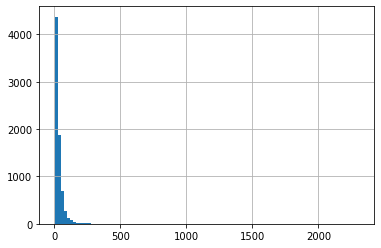

In [47]:
data.groupby('deviceID')['event'].count().hist(bins = 100)
print('Количество уникальных устройств:', data['deviceID'].nunique())
print('Среднее количество событий для одного устройства:', round(data.groupby('deviceID')['event'].count().mean()))
print('Максимальное количество событий для одного устройства:', data.groupby('deviceID')['event'].count().max())

Есть девайсы с высокой активностью, но в целом данные выглядят корректно.

**Время события (time):**

In [48]:
print('Охват времени датасета: от', data['time'].min(), 'до', data['time'].max(), '. Итого', (data['time'].max() - data['time'].min()))

Охват времени датасета: от 2019-07-25 04:43:36 до 2019-08-07 21:15:17 . Итого 13 days 16:31:41


Период времени в датасете охватывает 14 дней, единицей времени для анализа является день. Добавляю столбец с днями:

In [49]:
data['day'] = data['time'].dt.day

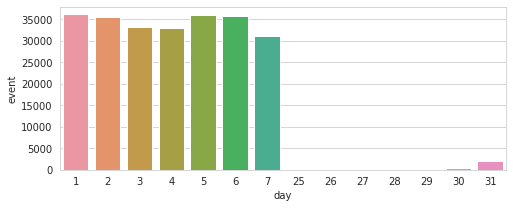

In [50]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 3))
sns.barplot(data = data.groupby('day',as_index = False)['event'].count(), x = 'day', y = 'event')

Полные данные есть только за первую неделю августа, а за последнюю неделю июля их почти нет. Убираю эти данные:

In [51]:
data = data[data['day']<25]

**Группа по номеру эксперимента (group).**

246 и 247 — контрольные группы, а 248 — экспериментальная.

Для начала гляну количество событий и пользователей в каждой группе:

In [52]:
data.groupby('group', as_index = False).agg({'event':'count', 'deviceID':'nunique'})

,group,event,deviceID
0,246,79302,2484
1,247,77022,2513
2,248,84563,2537


Все группы примерно одинаковые по кол-ву пользователей и событий, посмотрим все ли пользователи только в одной группе

In [53]:
counter = 0
for i in data['group'].unique():
    counter = counter + data[data['group'] == i]['deviceID'].nunique()
counter - data['deviceID'].nunique()

0

Шикарно. Каждый в своей группе. Эксперимент проводился корректно.

# 2. Изучение воронки событий

Для начала повторим список и количество событий в воронке на основе уже очищенных данных:

In [54]:
total(data.groupby('event',as_index = False)['deviceID'].count().sort_values(by = 'deviceID', ascending = False))

,event,deviceID
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005
0,total,240887


Скорее всего, Tutorial не относится к воронке, в дальнейшем я не буду его учитывать.

Пишу функцию, которая рассчитывает показатели по воронке:

In [55]:
def funnel_from_df(dataframe):
    funnel = (dataframe['deviceID'].nunique() - \
         dataframe.pivot_table(index = 'deviceID', columns = 'event', values = 'group', aggfunc = 'count').isna().sum())\
           .sort_values(ascending = False).head(4).reset_index()
    funnel.columns = ['event', 'number']
    funnel['share'] = funnel['number'] / funnel.loc[0,'number']
    return funnel

Считаю воронку для каждой группы эксперимента в отдельности:

In [56]:
funnel = pd.DataFrame(columns=['event', 'number', 'group'])
for i in data['group'].unique():
    funnel_group = funnel_from_df(data.query('group == @i'))
    funnel_group['group'] = i
    funnel = funnel.append(funnel_group, sort=True)
funnel = funnel.reset_index(drop=True)

In [57]:
fig = px.sunburst(funnel, path=['group', 'event'], values='number')
fig.show()

AttributeError: module 'plotly.express' has no attribute 'sunburst'

In [58]:
fig = px.funnel(funnel, x = 'number', y = 'event', color = 'group')
fig.show()

AttributeError: module 'plotly.express' has no attribute 'funnel'

In [24]:
funnel_from_df(data).style.format({'share': '{:,.0%}'.format})

,event,number,share
0,MainScreenAppear,7419,100%
1,OffersScreenAppear,4593,62%
2,CartScreenAppear,3734,50%
3,PaymentScreenSuccessful,3539,48%


Выводы, которые можно сделать по таблице:
* Наибольшие потери пользователей происходят на этапе перехода с главного экрана на экран предложений (-38%);
* Дальше процесс до завершения покупки идет с меньшими потерями: -12% и -2% от изначального количества пользователей для перехода в корзину и оплаты соответственно;
* До оплаты доходят 48% от изначальных пользователей.

In [25]:
funnel.style.format({'share': '{:,.0%}'.format})

,event,group,number,share
0,MainScreenAppear,246,2450,100%
1,OffersScreenAppear,246,1542,63%
2,CartScreenAppear,246,1266,52%
3,PaymentScreenSuccessful,246,1200,49%
4,MainScreenAppear,247,2476,100%
5,OffersScreenAppear,247,1520,61%
6,CartScreenAppear,247,1238,50%
7,PaymentScreenSuccessful,247,1158,47%
8,MainScreenAppear,248,2493,100%
9,OffersScreenAppear,248,1531,61%


Результаты экспериментальной группы (248) на каждом этапе почти такие же, как и у одной из контрольных (247), но на 2 процентных пункта ниже, чем у другой (246). Разница между группами возникает на этапе перехода от главного экрана к экрану предложений, и не исправляется на следующих этапах.

# 3. Изучение результатов эксперимента

Сколько пользователей в каждой экспериментальной группе?

In [26]:
groups_in_logs_full = data.pivot_table(index='group', values='deviceID', aggfunc=pd.Series.nunique).reset_index()
groups_in_logs_full

,group,deviceID
0,246,2484
1,247,2513
2,248,2537


In [27]:
groups_in_logs_full_forZ_pivot = data.pivot_table(index = 'event', columns='group', values='deviceID', aggfunc=pd.Series.nunique).reset_index()
groups_in_logs_full_forZ_pivot

group,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.

In [28]:
data.pivot_table(index = 'event', columns = 'group', values = 'deviceID', aggfunc = 'count').idxmax()

group
246    MainScreenAppear
247    MainScreenAppear
248    MainScreenAppear
dtype: object

Самое популярное событие во всех группах - показ главного экрана (MainScreenAppear).

* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
* Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным.
* Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Пишу функцию для z-тестов:

In [29]:
# клиентов, имевших событие воронки в каждой из групп (они же успехи для теста)


def Ztest (users_with_events_GROUP1_main, users_with_events_GROUP2_main, 
           users_with_events_GROUP1_offer, users_with_events_GROUP2_offer,
           users_with_events_GROUP1_basket, users_with_events_GROUP2_basket,
           users_with_events_GROUP1_pay, users_with_events_GROUP2_pay,
           total_unique_users_GROUP1, total_unique_users_GROUP2):
    
    alpha = .05 # критический уровень статистической значимости

    users_with_events_main = np.array([users_with_events_GROUP1_main, users_with_events_GROUP2_main])
    users_with_events_offer = np.array([users_with_events_GROUP1_offer, users_with_events_GROUP2_offer])
    users_with_events_basket = np.array([users_with_events_GROUP1_basket, users_with_events_GROUP2_basket])
    users_with_events_pay = np.array([users_with_events_GROUP1_pay, users_with_events_GROUP2_pay])
    
    total_unique_users = np.array([total_unique_users_GROUP1, total_unique_users_GROUP2])

# расчитаем процент успеха в каждой из групп
    p1_main = users_with_events_main[0]/total_unique_users[0]
    p2_main = users_with_events_main[1]/total_unique_users[1]
    
    p1_offer = users_with_events_offer[0]/total_unique_users[0]
    p2_offer = users_with_events_offer[1]/total_unique_users[1]
    
    p1_basket = users_with_events_basket[0]/total_unique_users[0]
    p2_basket = users_with_events_basket[1]/total_unique_users[1]
    
    p1_pay = users_with_events_pay[0]/total_unique_users[0]
    p2_pay = users_with_events_pay[1]/total_unique_users[1]
    
# расчитаем разницу долей успеха в каждой из групп
    difference_main = p1_main - p2_main
    difference_offer = p1_offer - p2_offer
    difference_basket = p1_basket - p2_basket
    difference_pay = p1_pay - p2_pay
    
# пропорция успехов в комбинированном датасете:
    p_combined_main = (users_with_events_main[0] + users_with_events_main[1]) / (total_unique_users[0] + total_unique_users[1])
    z_value_main = difference_main / mth.sqrt(p_combined_main * (1 - p_combined_main) * (1/total_unique_users[0] + 1/total_unique_users[1]))

    p_combined_offer = (users_with_events_offer[0] + users_with_events_offer[1]) / (total_unique_users[0] + total_unique_users[1])
    z_value_offer = difference_offer / mth.sqrt(p_combined_offer * (1 - p_combined_offer) * (1/total_unique_users[0] + 1/total_unique_users[1]))

    p_combined_basket = (users_with_events_basket[0] + users_with_events_basket[1]) / (total_unique_users[0] + total_unique_users[1])
    z_value_basket = difference_basket / mth.sqrt(p_combined_basket * (1 - p_combined_basket) * (1/total_unique_users[0] + 1/total_unique_users[1]))
    
    p_combined_pay = (users_with_events_pay[0] + users_with_events_pay[1]) / (total_unique_users[0] + total_unique_users[1])
    z_value_pay = difference_pay / mth.sqrt(p_combined_pay * (1 - p_combined_pay) * (1/total_unique_users[0] + 1/total_unique_users[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
# рассчитаем p-value

    p_value_main = (1 - distr.cdf(abs(z_value_main))) * 2
    p_value_offer = (1 - distr.cdf(abs(z_value_offer))) * 2
    p_value_basket = (1 - distr.cdf(abs(z_value_basket))) * 2
    p_value_pay = (1 - distr.cdf(abs(z_value_pay))) * 2


    print('p-значение MainScreenAppear: ', p_value_main)
    if (p_value_main < alpha):
        print("Отвергаем нулевую гипотезу: между долями захода посетителей в группах GROUP1/GROUP2 на главную страницу есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на главную страницу одинаковы, нет оснований считать доли разными")
        
    print('p-значение OffersScreenAppear: ', p_value_offer)
    if (p_value_offer < alpha):
        print("Отвергаем нулевую гипотезу: между долями захода посетителей в группах GROUP1/GROUP2 на страницу заказа есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу заказа одинаковы, нет оснований считать доли разными")
        
    print('p-значение CartScreenAppear: ', p_value_basket)
    if (p_value_basket < alpha):
        print("Отвергаем нулевую гипотезу: между долями захода посетителей в группах GROUP1/GROUP2 на страницу корзины есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу корзины одинаковы, нет оснований считать доли разными")
        
    print('p-значение PaymentScreenSuccessful: ', p_value_pay)    
    if (p_value_pay < alpha):
        print("Отвергаем нулевую гипотезу: между долями захода посетителей в группах GROUP1/GROUP2 на страницу оплаты есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу оплаты одинаковы, нет оснований считать доли разными")

**Проверяем Z критерием группы 246 и 247 (А1 А2 тест)**

In [30]:
Ztest_246_247_new = Ztest(groups_in_logs_full_forZ_pivot.loc[1, 246], groups_in_logs_full_forZ_pivot.loc[1, 247],
                          groups_in_logs_full_forZ_pivot.loc[2, 246], groups_in_logs_full_forZ_pivot.loc[2, 247],
                          groups_in_logs_full_forZ_pivot.loc[0, 246], groups_in_logs_full_forZ_pivot.loc[0, 247],
                          groups_in_logs_full_forZ_pivot.loc[3, 246], groups_in_logs_full_forZ_pivot.loc[3, 247],
                          groups_in_logs_full.loc[0, 'deviceID'], groups_in_logs_full.loc[1, 'deviceID'])

p-значение MainScreenAppear:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на главную страницу одинаковы, нет оснований считать доли разными
p-значение OffersScreenAppear:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу заказа одинаковы, нет оснований считать доли разными
p-значение CartScreenAppear:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу корзины одинаковы, нет оснований считать доли разными
p-значение PaymentScreenSuccessful:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу оплаты одинаковы, нет оснований считать доли разными


**Проверяем Z критерием группы 246 и 248 (А1 В тест)**

In [31]:
Ztest_246_248_new = Ztest(groups_in_logs_full_forZ_pivot.loc[1, 246], groups_in_logs_full_forZ_pivot.loc[1, 248],
                          groups_in_logs_full_forZ_pivot.loc[2, 246], groups_in_logs_full_forZ_pivot.loc[2, 248],
                          groups_in_logs_full_forZ_pivot.loc[0, 246], groups_in_logs_full_forZ_pivot.loc[0, 248],
                          groups_in_logs_full_forZ_pivot.loc[3, 246], groups_in_logs_full_forZ_pivot.loc[3, 248],
                          groups_in_logs_full.loc[0, 'deviceID'], groups_in_logs_full.loc[2, 'deviceID'])

p-значение MainScreenAppear:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на главную страницу одинаковы, нет оснований считать доли разными
p-значение OffersScreenAppear:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу заказа одинаковы, нет оснований считать доли разными
p-значение CartScreenAppear:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу корзины одинаковы, нет оснований считать доли разными
p-значение PaymentScreenSuccessful:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу оплаты одинаковы, нет оснований считать доли разными


**Проверяем Z критерием группы 247 и 248 (А2 В тест)**

In [32]:
Ztest_247_248_new = Ztest(groups_in_logs_full_forZ_pivot.loc[1, 247], groups_in_logs_full_forZ_pivot.loc[1, 248],
                          groups_in_logs_full_forZ_pivot.loc[2, 247], groups_in_logs_full_forZ_pivot.loc[2, 248],
                          groups_in_logs_full_forZ_pivot.loc[0, 247], groups_in_logs_full_forZ_pivot.loc[0, 248],
                          groups_in_logs_full_forZ_pivot.loc[3, 247], groups_in_logs_full_forZ_pivot.loc[3, 248],
                          groups_in_logs_full.loc[1, 'deviceID'], groups_in_logs_full.loc[2, 'deviceID'])

p-значение MainScreenAppear:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на главную страницу одинаковы, нет оснований считать доли разными
p-значение OffersScreenAppear:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу заказа одинаковы, нет оснований считать доли разными
p-значение CartScreenAppear:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу корзины одинаковы, нет оснований считать доли разными
p-значение PaymentScreenSuccessful:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу оплаты одинаковы, нет оснований считать доли разными


**Посмотрим уникальных пользователей в базе с полными логами**

In [34]:
groups_in_logs_full_forZ_pivot = data.pivot_table(index='event', columns='group', values='deviceID', aggfunc=pd.Series.nunique).reset_index()
groups_in_logs_full_forZ_pivot

group,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


**Подсчитаем по событиям общее количество уникальных пользователей групп А1 и А2 (246 и 247)**

In [35]:
groups_in_logs_full_forZ_pivot['total246_247'] = groups_in_logs_full_forZ_pivot[246] +  groups_in_logs_full_forZ_pivot[247]
groups_in_logs_full_forZ_pivot

group,event,246,247,248,total246_247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


In [37]:
unique246_247_total = groups_in_logs_full.loc[0, 'deviceID'] + groups_in_logs_full.loc[1, 'deviceID']
unique246_247_total

4997

**Проверяем Z критерием группы 246+247 и 248 (A1+А2 и В тест)**

In [38]:
Ztest_246and247_vs_248_new = Ztest(groups_in_logs_full_forZ_pivot.loc[1, 'total246_247'], groups_in_logs_full_forZ_pivot.loc[1, 248],
                          groups_in_logs_full_forZ_pivot.loc[2, 'total246_247'], groups_in_logs_full_forZ_pivot.loc[2, 248],
                          groups_in_logs_full_forZ_pivot.loc[0, 'total246_247'], groups_in_logs_full_forZ_pivot.loc[0, 248],
                          groups_in_logs_full_forZ_pivot.loc[3, 'total246_247'], groups_in_logs_full_forZ_pivot.loc[3, 248],
                          unique246_247_total, groups_in_logs_full.loc[2, 'deviceID'])

p-значение MainScreenAppear:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на главную страницу одинаковы, нет оснований считать доли разными
p-значение OffersScreenAppear:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу заказа одинаковы, нет оснований считать доли разными
p-значение CartScreenAppear:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу корзины одинаковы, нет оснований считать доли разными
p-значение PaymentScreenSuccessful:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, что доли захода посетилетей в группах GROUP1/GROUP2 на страницу оплаты одинаковы, нет оснований считать доли разными


* Если подставить p-value равное 0,1 (т.е. изменить уровень критической значимости с 5% до 10%), то один из тестов нам даст значимые различия в долях - а именно тест "CartScreenAppear246_248" - тест контрольной группы 246 и тестируемой 248.
* В случае с уровнем критической значимости 10% можно получить 1 из 10 ложный результат теста, мы из провели 16, соответственно, предполагаем, что результат теста "CartScreenAppear246_248" - является ошибочным.
* В случае исследования, результаты которого не связаны с жизнью и здоровьем или иным очень весомым и значимым для общества параметром, достаточен уровень значимости 5%, в случае если цена ошибки очень велика, стоит снизить цровень значимости до 1% или даже еще ниже (в зависимости от конкретной ситуации).
* В нашем случае уровень критической значимости (альфа) 5% можно считать оптимальным и на основе него принимать решение.

# Общий вывод:

На данный момент доли в наших выборках не имеют статистичекски значимых различий, причиной этому могут быть следующие факторы:

* Посетителям сайта не принципиален шрифт, и различий в контрольной и тестируемой группе действительно нет.
* Мы пока недостаточно долго проводим наше исследование, тогда стоит продлить сбор данных еще на 1 неделю и провести новые замеры.